In [10]:
%pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 38.7 MB/s eta 0:00:00


In [11]:
#pip install fiona

In [14]:
%pip install descartes

# Data Preprocessing

Goal: DataFrame where rows are pixels and columns are band data (features) and whether the pixel contains what we are looking for (binary label)

In [15]:
# image tools
import rasterio.mask
#import descartes
#import geom
#import fiona
import rasterio
import rasterio.plot
from descartes import PolygonPatch

In [16]:
# standard python tools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Feature Information (TIF File) -> Numpy Array

Taking the raw data (TIF File) and making it useable in Python. This is necessary for feature data

In [17]:
# helper function to plot image from img
def plot_from_img(path):
    """Inputs:
       - path: str, path to tif or jpg file
       Outputs:
       - plot of the image saved in file tif_path"""
    src = rasterio.open(path)
    plt.figure(figsize=[10,10])
    rasterio.plot.show((src, 1))

In [18]:
# example of tif -> image
plot_from_img("aoi2_after.TIF")

Protoytping band combinations to see if we can feature engineer a band combination that makes it easier to differentiate roads

In [ ]:
# helper function to plot image from tif
def plot_from_tif_custom(tif_path):
    """Inputs:
       - tif_path: str, path to tif file
       Outputs:
       - plot of the image saved in file tif_path,
         according to the band combination specified in the function"""
    src = rasterio.open(tif_path)
    band1 = src.read(1)
    band2 = src.read(2)
    band3 = src.read(3)
    band4 = src.read(4)
    band5 = src.read(5)
    band6 = src.read(6)
    band7 = src.read(7)
    band8 = src.read(8)

    # trying this band combination (EDIT BELOW)
    a = band8 - 0.5*band7 - 0.5*band6 #- band1 - band2 - band3 - band4 - band5
    a *= 1
    a = a.astype(np.uint8)
    plt.imshow(a)
    plt.show()

In [ ]:
# example of band combination experiment
plot_from_tif_custom("aoi2_after.TIF");

In [ ]:
pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 MB 11.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import cv2
from PIL import Image, ImageFilter

In [ ]:
# FROM GITHUB: helper function to record x,y coords
# source: https://gist.github.com/hernamesbarbara/68d073f551565de02ac5
def cartesian(arrays, out=None):
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = int(n / arrays[0].size)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

## Label Information (JPG File) -> Numpy Array

Taking a jpg file of label information and adding it to our processed data in python. This is necessary for supervised learning.

Example: Importing Landcover Label JPG for AOI1

In [ ]:
# hand drawn road labels saved as jpg. here we convert this jpg to a np array
label_src = rasterio.open("aoi1_land_after.jpg")
feature_src = rasterio.open("aoi1_after.TIF")
aoi_spectral = feature_src.read()
array = label_src.read(1)

# saving array dimensions
b,n,m = aoi_spectral.shape

# we want a np array of 1s and 0s, so we apply a transformation to get this
new_arr = array <= 250
new_arr = new_arr.astype(int)

# saving labels to df
road_label_df = pd.DataFrame(new_arr)

# plotting labels
plt.imshow(new_arr, interpolation='nearest')
plt.title("Land Cover Labels, AOI1")
plt.show()

In [ ]:
# helper function to turn band and label information into column vectors
def df_to_xy_col(df, xlim, ylim):
    """
    Input: df of xlim by ylim pixels
    Output: array of length xlim*ylim containing the entries of df
    """
    col = []
    for y in range(ylim):
        row = df.iloc[y,:]
        row = row.astype('int')
        col += list(row)
    return col

## Combining Features and Labels into one DF

Combining feature extraction and label extraction to complete a preprocessed dataframe

In [ ]:
def create_preprocessed_df(tif_feature_path, jpg_label_path):
    """Inputs:
       - tif_feature_path: string, path to tif file, which has spectral band data
       - jpg_label_path: string, path to jpg file containing label data
       Outputs:
       - df containing pixel coordinates, band data, and label data for each pixel in img
       """
    label_src = rasterio.open(jpg_label_path)
    feature_src = rasterio.open(tif_feature_path)
    aoi_spectral = feature_src.read()

    # saving array dimensions
    b,n,m = aoi_spectral.shape

    # we want a np array of 1s and 0s, so we apply a transformation to get this
    arr = label_src.read(1)
    new_arr = arr <= 250
    new_arr = new_arr.astype(int)

    # saving labels to df
    label_df = pd.DataFrame(new_arr)

    # initializing df at pixel granularity
    prelim = cartesian([range(n), range(m)])
    prelim
    aoi_df = pd.DataFrame(prelim, columns=["y","x"])

    # storing band information in 8 dataframes, one per band
    band_1_df = pd.DataFrame(aoi_spectral[0])
    band_2_df = pd.DataFrame(aoi_spectral[1])
    band_3_df = pd.DataFrame(aoi_spectral[2])
    band_4_df = pd.DataFrame(aoi_spectral[3])
    band_5_df = pd.DataFrame(aoi_spectral[4])
    band_6_df = pd.DataFrame(aoi_spectral[5])
    band_7_df = pd.DataFrame(aoi_spectral[6])
    band_8_df = pd.DataFrame(aoi_spectral[7])

    # converting band dfs to column vectors
    band_1 = df_to_xy_col(band_1_df, m, n)
    band_2 = df_to_xy_col(band_2_df, m, n)
    band_3 = df_to_xy_col(band_3_df, m, n)
    band_4 = df_to_xy_col(band_4_df, m, n)
    band_5 = df_to_xy_col(band_5_df, m, n)
    band_6 = df_to_xy_col(band_6_df, m, n)
    band_7 = df_to_xy_col(band_7_df, m, n)
    band_8 = df_to_xy_col(band_8_df, m, n)

    # adding bands 1 to 8 to df in the form of column vectors
    aoi_df["band1"] = band_1
    aoi_df["band2"] = band_2
    aoi_df["band3"] = band_3
    aoi_df["band4"] = band_4
    aoi_df["band5"] = band_5
    aoi_df["band6"] = band_6
    aoi_df["band7"] = band_7
    aoi_df["band8"] = band_8

    # adding labels to aoi df
    labels = df_to_xy_col(label_df, m, n)
    aoi_df["label"] = labels
    aoi_df["label"] = aoi_df["label"].astype('int')

    # return preprocessed df
    return aoi_df

Creating a processed dataframe for Road Models

(Avoid running more than once: this saves the processed data to a CSV file for indefinite use, as this code takes a long time to run)

In [ ]:
# initialize df
aoi_df = pd.DataFrame(columns = ['y','x','band1','band2','band3','band4',
                                 'band5','band6','band7','band8','label'])

# add preprocessed data for aoi 3,4,5 to produce this model
aoi_df = pd.concat([aoi_df, create_preprocessed_df("aoi3_after.TIF","aoi3_roads_after.jpg")])
aoi_df = pd.concat([aoi_df, create_preprocessed_df("aoi4_after.TIF","aoi4_roads_after.jpg")])
aoi_df = pd.concat([aoi_df, create_preprocessed_df("aoi5_after.TIF","aoi5_roads_after.jpg")])

# ensure labels are of type int
aoi_df["label"] = aoi_df["label"].astype('int')

In [ ]:
# saving processed data
aoi_df_roads = aoi_df

Creating a processed dataframe for Landcover Models

(Avoid running more than once: this saves the processed data to a CSV file for indefinite use, as this code takes a long time to run)

In [ ]:
# initialize df
aoi_df = pd.DataFrame(columns = ['y','x','band1','band2','band3','band4',
                                 'band5','band6','band7','band8','label'])

# add preprocessed data for aoi 3,4,5 to produce this model
aoi_df = pd.concat([aoi_df, create_preprocessed_df("aoi3_after.TIF","aoi3_land_after.jpg")])
aoi_df = pd.concat([aoi_df, create_preprocessed_df("aoi4_after.TIF","aoi4_land_after.jpg")])
aoi_df = pd.concat([aoi_df, create_preprocessed_df("aoi5_after.TIF","aoi5_land_after.jpg")])

# ensure labels are of type int
aoi_df["label"] = aoi_df["label"].astype('int')

In [ ]:
# saving processed data
aoi_df_land = aoi_df

Creating a processed dataframe for both Road and Landcover Models (two label columns), as this may save time in the future

(Avoid running more than once: this saves the processed data to a CSV file for indefinite use, as this code takes a long time to run)

In [ ]:
# combining the processed dataframes for roads and land
aoi_df = aoi_df_roads
aoi_df.rename(columns = {'label':'is_road'}, inplace = True)
aoi_df["is_landcover"] = aoi_df_land["label"]

# saving combined, processed data to csv
aoi_df.to_csv('road_land_data_aoi345.csv')

aoi_df.head(3)

,y,x,band1,band2,band3,band4,band5,band6,band7,band8,is_road,is_landcover
0,0,0,43,43,67,60,47,115,174,180,0,1
1,0,1,43,41,67,57,49,117,177,181,0,1
2,0,2,43,46,68,58,50,120,180,183,0,1


In [ ]:
# will stick with combined dataframe from here out, dropping aoi_df_roads and aoi_df_land to save memory
aoi_df_roads = aoi_df_land = 0

# Modeling

Goal: train models to identify roads and landcover in new saellite images, and evaluate their quality

In [ ]:
# machine learning libraries
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# reimporting preprocessed data treated earlier, to save time
aoi_df = pd.read_csv('road_land_data_aoi345.csv')

In [ ]:
# processed data, for both roads and landcover
aoi_df.head(3)

,Unnamed: 0,y,x,band1,band2,band3,band4,band5,band6,band7,band8,is_road,is_landcover
0,0,0,0,43,43,67,60,47,115,174,180,0,1
1,1,0,1,43,41,67,57,49,117,177,181,0,1
2,2,0,2,43,46,68,58,50,120,180,183,0,1


In [ ]:
# train test split
import random
random.seed(42)
from sklearn.model_selection import train_test_split

# (we also drop x and y values so these don't bias the model)

train, test = train_test_split(aoi_df, test_size=0.20)

# ROADS
X_train_roads, y_train_roads = train.loc[:,["band1","band2","band3","band4",
                                            "band5","band6","band7","band8"]],train.loc[:,["is_road"]]
X_test_roads,  y_test_roads  = test.loc[:,["band1","band2","band3","band4",
                                           "band5","band6","band7","band8"]],test.loc[:,["is_road"]]
# LAND
X_train_land, y_train_land = train.loc[:,["band1","band2","band3","band4",
                                          "band5","band6","band7","band8"]],train.loc[:,["is_landcover"]]
X_test_land,  y_test_land  = test.loc[:,["band1","band2","band3","band4",
                                         "band5","band6","band7","band8"]],test.loc[:,["is_landcover"]]

In [ ]:
# what the training data looks like
X_train.head(3)

,band1,band2,band3,band4,band5,band6,band7,band8
190702,42,50,45,47,49,41,63,64
1133884,60,76,109,109,110,149,192,199
3094628,40,28,50,39,39,89,179,175


## Prediction -> Image Helper Functions

Our model is pixel level, so we must run it m x n times (one for each pixel in the image) and reshape the results to display our prediction as an image.

In [ ]:
from skimage import morphology
import skimage

In [ ]:
def predict_image(model, tif_feature_path, threshold=0.5):
    """
    Inputs:
    - model: a model that takes pixel information as input and outputs a binary classification
    - tiff_feature_path: string, path to the tiff file with band information
    - threshold: float, if predicted probability >= threshold, binary prediction will be 1
    Outputs:
    - a plot of pixel-level predictions of whether a road is present
    """
    # convert input data from tif to df
    tif_src = rasterio.open(tif_feature_path)
    tif_arr = tif_src.read()
    b,n,m = tif_arr.shape

    # initialize df with just x and y values. should be m*n rows
    prelim = cartesian([range(n), range(m)])
    prelim
    df = pd.DataFrame(prelim, columns=["y","x"])

    band_1_df = pd.DataFrame(tif_arr[0])
    band_2_df = pd.DataFrame(tif_arr[1])
    band_3_df = pd.DataFrame(tif_arr[2])
    band_4_df = pd.DataFrame(tif_arr[3])
    band_5_df = pd.DataFrame(tif_arr[4])
    band_6_df = pd.DataFrame(tif_arr[5])
    band_7_df = pd.DataFrame(tif_arr[6])
    band_8_df = pd.DataFrame(tif_arr[7])

    band_1 = df_to_xy_col(band_1_df, m, n)
    print("band 1 processed")
    band_2 = df_to_xy_col(band_2_df, m, n)
    print("band 2 processed")
    band_3 = df_to_xy_col(band_3_df, m, n)
    print("band 3 processed")
    band_4 = df_to_xy_col(band_4_df, m, n)
    print("band 4 processed")
    band_5 = df_to_xy_col(band_5_df, m, n)
    print("band 5 processed")
    band_6 = df_to_xy_col(band_6_df, m, n)
    print("band 6 processed")
    band_7 = df_to_xy_col(band_7_df, m, n)
    print("band 7 processed")
    band_8 = df_to_xy_col(band_8_df, m, n)
    print("band 8 processed")

    df["band1"] = band_1
    df["band2"] = band_2
    df["band3"] = band_3
    df["band4"] = band_4
    df["band5"] = band_5
    df["band6"] = band_6
    df["band7"] = band_7
    df["band8"] = band_8
    # band combinations
    #df["TM3/TM4"] = df["band3"] / df["band4"]
    #df["TM3/TM5"] = df["band3"] / df["band5"]
    #df["inv789"] =  df["band8"] - 0.5*df["band7"] - 0.5*df["band6"]

    # for each row in this df, predict whether that pixel is 1 or 0
    # also: exclude x and y coordinate information so as not to bias results
    # also: only predict 1 if the predicted probability of class 1 is at least the threshold
    predicted_proba = model.predict_proba(df.loc[:,["band1","band2","band3","band4",
                                                    "band5","band6","band7","band8"]])
    predicted = (predicted_proba[:,1] >= threshold).astype('int')

    # reshape predictions into n x m array
    predicted = np.reshape(predicted, (n,m))

    # plot results
    # apply median blur to remove noise from predictions (only aesthetic for now)
    predicted_denoised = cv2.medianBlur(predicted, 1)

    # FROM STACK OVERFLOW
    # read the image, grayscale it, binarize it, then remove small pixel clusters
    im = predicted
    grayscale = im
    binarized = im
    processed = morphology.remove_small_objects(binarized.astype(bool), min_size=3, connectivity=2).astype(int)

    # black out pixels
    mask_x, mask_y = np.where(processed == 0)
    im[mask_x, mask_y] = 0

    # plot the result
    plt.figure(figsize=[10,10])
    plt.imshow(im)

## Model 0: Ground Truth

In [ ]:
# roads and landcover truth for AOI1
(plot_from_img("aoi1_roads_after.jpg"), plot_from_img("aoi1_land_after.jpg"))

In [ ]:
# roads and landcover truth for AOI2
(plot_from_img("aoi2_roads_after.jpg"), plot_from_img("aoi2_land_after.jpg"))

## Model 1: CART

In [ ]:
from sklearn.tree import DecisionTreeClassifier

### CART on Roads

In [ ]:
# fitting a CART model on pixel-level data
cart_model_roads = DecisionTreeClassifier()
cart_model_roads.fit(X_train_roads, np.array(y_train_roads.iloc[:,0]))
print(cart_model_roads)

DecisionTreeClassifier()


In [ ]:
# evaluating CART performance
expected_y  = y_test_roads
predicted_y = cart_model_roads.predict(X_test_roads)

print("Performance of CART on Road Identification:")
print(metrics.classification_report(expected_y, predicted_y))
print("Confusion Matrix:")
print(metrics.confusion_matrix(expected_y, predicted_y))

Performance of CART on Road Identification:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   2492068
           1       0.26      0.32      0.29     21003

    accuracy                           0.99   2513071
   macro avg       0.63      0.66      0.64   2513071
weighted avg       0.99      0.99      0.99   2513071

Confusion Matrix:
[[2473238   18830]
 [  14235    6768]]


In [ ]:
# predicted probabilities of class 1
y_pred_proba = cart_model_roads.predict_proba(X_test_roads)[::,1]
cart_roads_proba = y_pred_proba

# recovering AUC
auc = metrics.roc_auc_score(y_test_roads, y_pred_proba)
print("CART AUC (Roads):")
auc

CART AUC (Roads):


0.657235786086612

In [ ]:
# AOI1 Road Identification, CART
predict_image(cart_model_roads, "aoi1_after.TIF")

In [ ]:
# AOI2 Road Identification, CART
predict_image(cart_model_roads, "aoi2_after.TIF")

### CART on Land Cover

In [ ]:
# fitting a CART model on pixel-level data
cart_model_land = DecisionTreeClassifier()
cart_model_land.fit(X_train_land, np.array(y_train_land.iloc[:,0]))
print(cart_model_land)

DecisionTreeClassifier()


In [ ]:
# evaluating CART performance
expected_y  = y_test_land
predicted_y = cart_model_land.predict(X_test_land)

print("Performance of CART on Land Cover Identification:")
print(metrics.classification_report(expected_y, predicted_y))
print("Confusion Matrix:")
print(metrics.confusion_matrix(expected_y, predicted_y))

Performance of CART on Land Cover Identification:
              precision    recall  f1-score   support

           0       0.63      0.66      0.64    674263
           1       0.87      0.86      0.87   1838808

    accuracy                           0.81   2513071
   macro avg       0.75      0.76      0.76   2513071
weighted avg       0.81      0.81      0.81   2513071

Confusion Matrix:
[[ 443577  230686]
 [ 258791 1580017]]


In [ ]:
# predicted probabilities of class 1
y_pred_proba = cart_model_land.predict_proba(X_test_land)[::,1]
cart_land_proba = y_pred_proba

# recovering AUC
auc = metrics.roc_auc_score(y_test_land, y_pred_proba)
print("CART AUC (Land Cover):")
auc

CART AUC (Land Cover):


0.7585619549134709

In [ ]:
# AOI1 Land Cover Identification, CART
predict_image(cart_model_land, "aoi1_after.TIF")

In [ ]:
# AOI2 Land Cover Identification, CART
predict_image(cart_model_land, "aoi2_after.TIF")

## Method 2: Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

### Random Forests on Roads

In [ ]:
# fitting a random forest model on pixel-level data
rf_model_roads = RandomForestClassifier()
rf_model_roads.fit(X_train_roads, np.array(y_train_roads.iloc[:,0]))
print(rf_model_roads)

RandomForestClassifier()


In [ ]:
# evaluating random forest performance
expected_y  = y_test_roads
predicted_y = rf_model_roads.predict(X_test_roads)

print("Performance of Random Forest on Road Identification:")
print(metrics.classification_report(expected_y, predicted_y))
print("Confusion Matrix:")
print(metrics.confusion_matrix(expected_y, predicted_y))

Performance of Random Forest on Road Identification:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   2492068
           1       0.78      0.27      0.40     21003

    accuracy                           0.99   2513071
   macro avg       0.89      0.64      0.70   2513071
weighted avg       0.99      0.99      0.99   2513071

Confusion Matrix:
[[2490437    1631]
 [  15312    5691]]


In [ ]:
# predicted probabilities of class 1
y_pred_proba = rf_model_roads.predict_proba(X_test_roads)[::,1]
rf_roads_proba = y_pred_proba

# recovering AUC
auc = metrics.roc_auc_score(y_test_roads, y_pred_proba)
print("Random Forest AUC (Roads):")
auc

Random Forest AUC (Roads):


0.8898897137306321

In [ ]:
# AOI1 Road Identification, Random Forest
predict_image(rf_model_roads, "aoi1_after.TIF")

In [ ]:
# AOI2 Road Identification, Random Forest
predict_image(rf_model_roads, "aoi2_after.TIF")

### Random Forests on Land Cover

In [ ]:
# fitting a random forest model on pixel-level data
rf_model_land = RandomForestClassifier()
rf_model_land.fit(X_train_land, np.array(y_train_land.iloc[:,0]))
print(rf_model_land)

RandomForestClassifier()


In [ ]:
# evaluating random forest performance
expected_y  = y_test_land
predicted_y = rf_model_land.predict(X_test_land)

print("Performance of Random Forest on Land Identification:")
print(metrics.classification_report(expected_y, predicted_y))
print("Confusion Matrix:")
print(metrics.confusion_matrix(expected_y, predicted_y))

Performance of Random Forest on Land Identification:
              precision    recall  f1-score   support

           0       0.82      0.70      0.75    674263
           1       0.90      0.94      0.92   1838808

    accuracy                           0.88   2513071
   macro avg       0.86      0.82      0.84   2513071
weighted avg       0.87      0.88      0.87   2513071

Confusion Matrix:
[[ 472033  202230]
 [ 107046 1731762]]


In [ ]:
# predicted probabilities of class 1
y_pred_proba = rf_model_land.predict_proba(X_test_land)[::,1]
rf_land_proba = y_pred_proba

# recovering AUC
auc = metrics.roc_auc_score(y_test_land, y_pred_proba)
print("Random Forest AUC (Land Cover):")
auc

Random Forest AUC (Land Cover):


0.9101019991052174

In [ ]:
# AOI1 Land Cover Identification, Random Forest
predict_image(rf_model_land, "aoi1_after.TIF")

In [ ]:
# AOI2 Land Cover Identification, Random Forest
predict_image(rf_model_land, "aoi2_after.TIF")

## Method 3: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

### Logistic Regression on Roads

In [ ]:
# fitting a logistic regression model on pixel-level data
lr_model_roads = LogisticRegression()
lr_model_roads.fit(X_train_roads, np.array(y_train_roads.iloc[:,0]))
print(lr_model_roads)

LogisticRegression()


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# evaluating logistic regression performance
expected_y  = y_test_roads
predicted_y = lr_model.predict(X_test_roads)

print("Performance of Logistic Regression on Road Identification:")
print(metrics.classification_report(expected_y, predicted_y))
print("Confusion Matrix:")
print(metrics.confusion_matrix(expected_y, predicted_y))

Performance of Logistic Regression on Road Identification:
              precision    recall  f1-score   support

           0       0.97      0.19      0.32   2492068
           1       0.00      0.32      0.01     21003

    accuracy                           0.19   2513071
   macro avg       0.49      0.26      0.16   2513071
weighted avg       0.96      0.19      0.32   2513071

Confusion Matrix:
[[ 474357 2017711]
 [  14223    6780]]


In [ ]:
# predicted probabilities of class 1
y_pred_proba = lr_model_roads.predict_proba(X_test_roads)[::,1]
lr_roads_proba = y_pred_proba

# recovering AUC
auc = metrics.roc_auc_score(y_test_roads, y_pred_proba)
print("Logistic Regression AUC (Roads):")
auc

Logistic Regression AUC (Roads):


0.8858738442171677

In [ ]:
# AOI1 Road Identification, Logistic Regression
predict_image(lr_model_roads, "aoi1_after.TIF")

In [ ]:
# AOI2 Road Identification, Logistic Regression
predict_image(lr_model_roads, "aoi2_after.TIF")

Understanding predictions:\
Logistic regression has an interpretability advantage in that the coefficients for different features reveal how much they contribute to the model's decision. Want: to visualize the coefficients for this logistic regression model

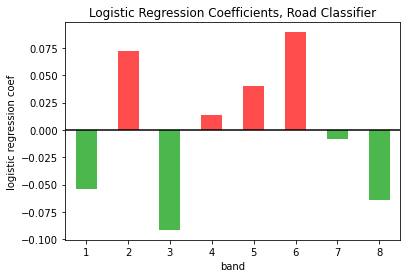

In [ ]:
# creating a dataframe where rows are features (bands)
# and columns are band and logistic regression coef
to_plot = pd.DataFrame(np.array([1,2,3,4,5,6,7,8]),columns=["feature"])
to_plot["coef"] = lr_model_roads.coef_[0]

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()

to_plot['sign'] = to_plot['coef'] > 0
to_plot['coef'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}),
                      ax=ax)
ax.set_xticklabels(range(1,9), rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("band");
ax.set_ylabel("logistic regression coef");
ax.set_title("Logistic Regression Coefficients, Road Classifier");

### Logistic Regression on Land Cover

In [ ]:
# fitting a logistic regression model on pixel-level data
lr_model_land = LogisticRegression()
lr_model_land.fit(X_train_land, np.array(y_train_land.iloc[:,0]))
print(lr_model_land)

LogisticRegression()


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# evaluating logistic regression performance
expected_y  = y_test_land
predicted_y = lr_model_land.predict(X_test_land)

print("Performance of Logistic Regression on Land Cover Identification:")
print(metrics.classification_report(expected_y, predicted_y))
print("Confusion Matrix:")
print(metrics.confusion_matrix(expected_y, predicted_y))

Performance of Logistic Regression on Land Cover Identification:
              precision    recall  f1-score   support

           0       0.80      0.59      0.68    674263
           1       0.86      0.94      0.90   1838808

    accuracy                           0.85   2513071
   macro avg       0.83      0.77      0.79   2513071
weighted avg       0.84      0.85      0.84   2513071

Confusion Matrix:
[[ 395306  278957]
 [ 101389 1737419]]


In [ ]:
# predicted probabilities of class 1
y_pred_proba = lr_model_land.predict_proba(X_test_land)[::,1]
lr_land_proba = y_pred_proba

# recovering AUC
auc = metrics.roc_auc_score(y_test_land, y_pred_proba)
print("Logistic Regression AUC (Land):")
auc

Logistic Regression AUC (Land):


0.8707130049816797

In [ ]:
# AOI1 Land Identification, Logistic Regression
predict_image(lr_model_land, "aoi1_after.TIF")

In [ ]:
# AOI2 Land Identification, Logistic Regression
predict_image(lr_model_land, "aoi2_after.TIF")

Understanding predictions:\
Logistic regression has an interpretability advantage in that the coefficients for different features reveal how much they contribute to the model's decision. Want: to visualize the coefficients for this logistic regression model

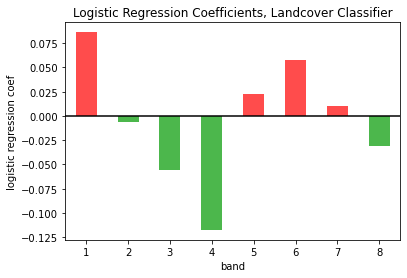

In [ ]:
# creating a dataframe where rows are features (bands)
# and columns are band and logistic regression coef
to_plot = pd.DataFrame(np.array([1,2,3,4,5,6,7,8]),columns=["feature"])
to_plot["coef"] = lr_model_land.coef_[0]

# plotting feature coefs (and by extension, feature importance)
fig, ax = plt.subplots()

to_plot['sign'] = to_plot['coef'] > 0
to_plot['coef'].plot(kind='bar', color=to_plot.sign.map({True: (1.0, 0, 0, 0.7), False: (0, 0.6, 0, 0.7)}),
                      ax=ax)
ax.set_xticklabels(range(1,9), rotation = 0);
ax.axhline(0, color='k');
ax.set_xlabel("band");
ax.set_ylabel("logistic regression coef");
ax.set_title("Logistic Regression Coefficients, Landcover Classifier");

## Method 4: XGBoost

In [ ]:
pip install xgboost


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from xgboost import XGBClassifier

### XGBoost on Roads

In [ ]:
# fitting an xgboost model on pixel-level data
xgb_roads = XGBClassifier()
xgb_roads.fit(X_train_roads, np.array(y_train_roads.iloc[:,0]))
print(xgb_roads)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)


In [ ]:
# evaluating xgboost performance
expected_y  = y_test_roads
predicted_y = xgb_roads.predict(X_test_roads)

print("Performance of XGboost on Road Identification:")
print(metrics.classification_report(expected_y, predicted_y))
print("Confusion Matrix:")
print(metrics.confusion_matrix(expected_y, predicted_y))

Performance of XGboost on Road Identification:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   2492068
           1       0.73      0.25      0.37     21003

    accuracy                           0.99   2513071
   macro avg       0.86      0.62      0.68   2513071
weighted avg       0.99      0.99      0.99   2513071

Confusion Matrix:
[[2490196    1872]
 [  15854    5149]]


In [ ]:
# predicted probabilities of class 1
y_pred_proba = xgb_roads.predict_proba(X_test_roads)[::,1]
xgb_roads_proba = y_pred_proba

# recovering AUC
auc = metrics.roc_auc_score(y_test_roads, y_pred_proba)
print("XGBoost AUC (Roads):")
auc

XGBoost AUC (Roads):


0.9302177042783898

In [ ]:
# AOI1 Road Identification, XGBoost
predict_image(xgb_roads, "aoi1_after.TIF")

In [ ]:
# AOI2 Road Identification, XGBoost
predict_image(xgb_roads, "aoi2_after.TIF")

### XGBoost on Land Cover

In [ ]:
# fitting an xgboost model on pixel-level data
xgb_land = XGBClassifier()
xgb_land.fit(X_train_land, np.array(y_train_land.iloc[:,0]))
print(xgb_land)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)


In [ ]:
# evaluating xgboost performance
expected_y  = y_test_land
predicted_y = xgb_roads.predict(X_test_land)

print("Performance of XGboost on Land Cover Identification:")
print(metrics.classification_report(expected_y, predicted_y))
print("Confusion Matrix:")
print(metrics.confusion_matrix(expected_y, predicted_y))

Performance of XGboost on Land Cover Identification:
              precision    recall  f1-score   support

           0       0.27      0.99      0.42    674263
           1       0.36      0.00      0.00   1838808

    accuracy                           0.27   2513071
   macro avg       0.32      0.50      0.21   2513071
weighted avg       0.34      0.27      0.12   2513071

Confusion Matrix:
[[ 669800    4463]
 [1836250    2558]]


In [ ]:
# predicted probabilities of class 1
y_pred_proba = xgb_land.predict_proba(X_test_land)[::,1]
xgb_land_proba = y_pred_proba

# recovering AUC
auc = metrics.roc_auc_score(y_test_land, y_pred_proba)
print("XGBoost AUC (Land Cover):")
auc

XGBoost AUC (Land Cover):


0.9102482206345875

In [ ]:
# AOI1 Land Cover Identification, XGBoost
predict_image(xgb_land, "aoi1_after.TIF")

In [ ]:
# AOI2 Land Cover Identification, XGBoost
predict_image(xgb_land, "aoi1_after.TIF")

# Model Results Summary

## ROC Curve and AUC

Roads: Comparing ROC Curves and AUCs between all 4 road models

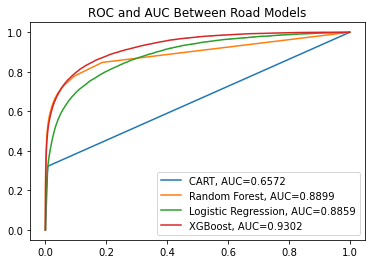

In [ ]:
plt.figure(1).clf()
# CART roads
y_pred = cart_roads_proba
fpr, tpr, _ = metrics.roc_curve(y_test_roads, y_pred)
auc = round(metrics.roc_auc_score(y_test_roads, y_pred), 4)
plt.plot(fpr,tpr,label="CART, AUC="+str(auc));

# RF roads
y_pred = rf_roads_proba
fpr, tpr, _ = metrics.roc_curve(y_test_roads, y_pred)
auc = round(metrics.roc_auc_score(y_test_roads, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc));

# LR roads
y_pred = lr_roads_proba
fpr, tpr, _ = metrics.roc_curve(y_test_roads, y_pred)
auc = round(metrics.roc_auc_score(y_test_roads, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc));

# XGB roads
y_pred = xgb_roads_proba
fpr, tpr, _ = metrics.roc_curve(y_test_roads, y_pred)
auc = round(metrics.roc_auc_score(y_test_roads, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc));

plt.title("ROC and AUC Between Road Models");
plt.legend();

Landcover: Comparing ROC Curves and AUCs between all 4 landcover models

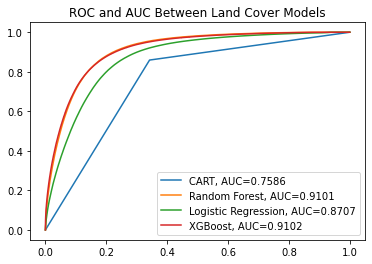

In [ ]:
plt.figure(1).clf()
# CART land
y_pred = cart_land_proba
fpr, tpr, _ = metrics.roc_curve(y_test_land, y_pred)
auc = round(metrics.roc_auc_score(y_test_land, y_pred), 4)
plt.plot(fpr,tpr,label="CART, AUC="+str(auc));

# RF land
y_pred = rf_land_proba
fpr, tpr, _ = metrics.roc_curve(y_test_land, y_pred)
auc = round(metrics.roc_auc_score(y_test_land, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc));

# LR land
y_pred = lr_land_proba
fpr, tpr, _ = metrics.roc_curve(y_test_land, y_pred)
auc = round(metrics.roc_auc_score(y_test_land, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc));

# XGB land
y_pred = xgb_land_proba
fpr, tpr, _ = metrics.roc_curve(y_test_land, y_pred)
auc = round(metrics.roc_auc_score(y_test_land, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc));

plt.title("ROC and AUC Between Land Cover Models");
plt.legend();

# Feature Engineering: Trying Band Combinations

Certain spectral band combinations are well-suited for picking up vegetation (landcover) or urban surfaces (roads), so it is worth seeing whether adding band combinations as features improves model performance

In [ ]:
# reference variables for df columns
b1 = aoi_df["band1"]
b2 = aoi_df["band2"]
b3 = aoi_df["band3"]
b4 = aoi_df["band4"]
b5 = aoi_df["band5"]
b6 = aoi_df["band6"]
b7 = aoi_df["band7"]
b8 = aoi_df["band8"]

Source: https://web.pdx.edu/~nauna/resources/10_BandCombinations.htm

NOTE: +1 is added to the denominator of each ratio to avoid division by zero errors while keeping input data as integers

"TM3/TM4: This ratio has defined barren lands and urban area uniquely. But it could not define water body, forests and croplands."

In [ ]:
aoi_df["TM3/TM4"] = b1 / (b4+1)

"TM4/TM3: This ratio distinguished vegetation, water and croplands. It has enhanced forests, barren lands. Because forests or vegetation exhibits higher reflectance in near IR region (0.76 -0.90u m) and strong absorption in red region (0.63-0.69u m) region. This ratio uniquely defines the distribution of vegetation. The lighter the tone, the greater the amount of vegetation present."

In [ ]:
aoi_df["TM4/TM3"] = b4 / (b3+1)

"TM5/TM7: This ratio separated land and water uniquely. Since soils exhibit strong absorption in the band 7 (2.08 -2.35u m) and high reflectance in band 5 (1.55 - 1.75u m), soil has been enhanced in this ratio. Land has appeared as lighter tone and water appeared as dark tone."

In [ ]:
aoi_df["TM5/TM7"] = b5 / (b7+1)

"TM2/TM3: this ratio has distinguished croplands, barren lands sharply. But it hasn’t separated croplands, forests and water body. Both forests and water body has appeared as lighter tone and barren land appeared has dark tone. It did not enhance urban area. Chlorophyll has strong reflectance in the band 2 (0.52 -0.60u m) region and strong absorption in the band 3(0.63 -0.69u m) region, vegetation has appeared as higher tone."

In [ ]:
aoi_df["TM2/TM3"] = b2 / (b3+1)

"TM3/TM2: This ratio has separated forests and croplands. Because band 3 (0.63-0.69m m) is the red chlorophyll absorption band of healthy green vegetation and band 2 (0.52-0.69m m) is the reflectance band from leaf surfaces. This ratio can be useful to discriminate broad classes of vegetation. Croplands have appeared as lighter (brighter) tone and forests appeared as dark tone."

In [ ]:
aoi_df["TM3/TM2"] = b3 / (b2+1)

"TM4/TM5: It enhances the water body, vegetation and presence of moisture content in the croplands. Water body has appeared as dark tone and vegetation as lighter tone. Because water is a strong absorber in near IR region( band4) and higher reflectance in band 5 region. It can be useful for discriminating water bodies from land."

In [ ]:
aoi_df["TM4/TM5"] = b4 / (b5+1)

"TM5/TM4: It has separated water body from forest, barren lands and vegetation. In this ratio water has appeared as dark tone and forest, barren lands, bare croplands all have exhibited brighter tone."

In [ ]:
aoi_df["TM5/TM4"] = b5 / (b4+1)

"TM5/TM7: It has separated water body from lands (soils). It has also enhanced presence of moisture in croplands. All water bodies appeared as dark tone. Both band 5 and band 7 are sensitive to moisture content variation in soils and vegetation. This ratio is useful for crop-drought studies and plant vigor investigations."

In [ ]:
aoi_df["TM5/TM7"] = b5 / (b7+1)

"TM3/TM5: This ratio enhances barren lands, highways, street patterns within the urban areas and urban built-up or cemented areas. It could not enhance the clear water but it enhanced turbid water. This ratio is useful for observing differences in water turbidity. Barren lands, highways, urban and built-up areas have appeared as lighter tone and forests, water body and croplands appeared as dark tone."

In [ ]:
aoi_df["TM3/TM5"] = b3 / (b5+1)

"TM7/TM2: This ratio has separated forests and croplands. But it could not separated forests from water body; both features have appeared as dark tone. It enhances highways, urban and built-up areas and croplands and all of them have appeared as lighter tone."

In [ ]:
aoi_df["TM7/TM2"] = b7 / (b2+1)

## Assessing Impact of Band Combinations on Model Performance

In [ ]:
# train test split
import random
random.seed(42)
from sklearn.model_selection import train_test_split

# (we also drop x and y values so these don't bias the model)

train, test = train_test_split(aoi_df, test_size=0.20)

# ROADS
X_train_roads, y_train_roads = train.loc[:,["band1","band2","band3","band4",
                                            "band5","band6","band7","band8",
                                            'TM4/TM3','TM5/TM7','TM2/TM3','TM3/TM2',
                                            'TM4/TM5','TM5/TM4','TM3/TM5','TM7/TM2']],train.loc[:,["is_road"]]
X_test_roads,  y_test_roads  = test.loc[:,["band1","band2","band3","band4",
                                           "band5","band6","band7","band8",
                                           'TM4/TM3','TM5/TM7','TM2/TM3','TM3/TM2',
                                           'TM4/TM5','TM5/TM4','TM3/TM5','TM7/TM2']],test.loc[:,["is_road"]]
# LAND
X_train_land, y_train_land = train.loc[:,["band1","band2","band3","band4",
                                          "band5","band6","band7","band8",
                                          'TM4/TM3','TM5/TM7','TM2/TM3','TM3/TM2',
                                          'TM4/TM5','TM5/TM4','TM3/TM5','TM7/TM2']],train.loc[:,["is_landcover"]]
X_test_land,  y_test_land  = test.loc[:,["band1","band2","band3","band4",
                                         "band5","band6","band7","band8",
                                         'TM4/TM3','TM5/TM7','TM2/TM3','TM3/TM2',
                                         'TM4/TM5','TM5/TM4','TM3/TM5','TM7/TM2']],test.loc[:,["is_landcover"]]

## CART w/ Band Combos

### Roads

In [ ]:
# fitting a CART model on pixel-level data
cart_model_roads = DecisionTreeClassifier()
cart_model_roads.fit(X_train_roads, np.array(y_train_roads.iloc[:,0]))
print(cart_model_roads)

DecisionTreeClassifier()


In [ ]:
# evaluating CART performance
expected_y  = y_test_roads
predicted_y = cart_model_roads.predict(X_test_roads)

print("Performance of CART on Road Identification (with band combinations):")
print(metrics.classification_report(expected_y, predicted_y))
print("Confusion Matrix:")
print(metrics.confusion_matrix(expected_y, predicted_y))

Performance of CART on Road Identification (with band combinations):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   2492094
           1       0.27      0.32      0.29     20977

    accuracy                           0.99   2513071
   macro avg       0.63      0.66      0.64   2513071
weighted avg       0.99      0.99      0.99   2513071

Confusion Matrix:
[[2473921   18173]
 [  14294    6683]]


In [ ]:
# predicted probabilities of class 1
y_pred_proba = cart_model_roads.predict_proba(X_test_roads)[::,1]
cart_roads_proba = y_pred_proba

# recovering AUC
auc = metrics.roc_auc_score(y_test_roads, y_pred_proba)
print("CART AUC (Roads):")
auc

CART AUC (Roads):


0.6555872620506779

### Land Cover

In [ ]:
# fitting a CART model on pixel-level data
cart_model_land = DecisionTreeClassifier()
cart_model_land.fit(X_train_land, np.array(y_train_land.iloc[:,0]))
print(cart_model_land)

DecisionTreeClassifier()


In [ ]:
# evaluating CART performance
expected_y  = y_test_land
predicted_y = cart_model_land.predict(X_test_land)

print("Performance of CART on Land Cover Identification (with band combinations):")
print(metrics.classification_report(expected_y, predicted_y))
print("Confusion Matrix:")
print(metrics.confusion_matrix(expected_y, predicted_y))

Performance of CART on Land Cover Identification (with band combinations):
              precision    recall  f1-score   support

           0       0.63      0.65      0.64    674545
           1       0.87      0.86      0.87   1838526

    accuracy                           0.81   2513071
   macro avg       0.75      0.76      0.76   2513071
weighted avg       0.81      0.81      0.81   2513071

Confusion Matrix:
[[ 441778  232767]
 [ 256048 1582478]]


In [ ]:
# predicted probabilities of class 1
y_pred_proba = cart_model_land.predict_proba(X_test_land)[::,1]
cart_land_proba = y_pred_proba

# recovering AUC
auc = metrics.roc_auc_score(y_test_land, y_pred_proba)
print("CART AUC (Land Cover):")
auc

CART AUC (Land Cover):


0.7578281074327344

## Random Forest w/ Band Combos

### Roads

In [ ]:
# fitting a random forest model on pixel-level data
rf_model_roads = RandomForestClassifier()
rf_model_roads.fit(X_train_roads, np.array(y_train_roads.iloc[:,0]))
print(rf_model_roads)

RandomForestClassifier()


In [ ]:
# evaluating random forest performance
expected_y  = y_test_roads
predicted_y = rf_model_roads.predict(X_test_roads)

print("Performance of Random Forest on Road Identification (with band combinations):")
print(metrics.classification_report(expected_y, predicted_y))
print("Confusion Matrix:")
print(metrics.confusion_matrix(expected_y, predicted_y))

Performance of Random Forest on Road Identification (with band combinations):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   2492094
           1       0.76      0.28      0.41     20977

    accuracy                           0.99   2513071
   macro avg       0.88      0.64      0.70   2513071
weighted avg       0.99      0.99      0.99   2513071

Confusion Matrix:
[[2490276    1818]
 [  15117    5860]]


In [ ]:
# predicted probabilities of class 1
y_pred_proba = rf_model_roads.predict_proba(X_test_roads)[::,1]
rf_roads_proba = y_pred_proba

# recovering AUC
auc = metrics.roc_auc_score(y_test_roads, y_pred_proba)
print("Random Forest AUC (Roads):")
auc

Random Forest AUC (Roads):


0.8901728533517523

### Land Cover

In [ ]:
# fitting a random forest model on pixel-level data
rf_model_land = RandomForestClassifier()
rf_model_land.fit(X_train_land, np.array(y_train_land.iloc[:,0]))
print(rf_model_land)

RandomForestClassifier()


In [ ]:
# evaluating random forest performance
expected_y  = y_test_land
predicted_y = rf_model_land.predict(X_test_land)

print("Performance of Random Forest on Land Identification: (with band combinations)")
print(metrics.classification_report(expected_y, predicted_y))
print("Confusion Matrix:")
print(metrics.confusion_matrix(expected_y, predicted_y))

Performance of Random Forest on Land Identification: (with band combinations)
              precision    recall  f1-score   support

           0       0.81      0.69      0.75    674545
           1       0.89      0.94      0.92   1838526

    accuracy                           0.87   2513071
   macro avg       0.85      0.82      0.83   2513071
weighted avg       0.87      0.87      0.87   2513071

Confusion Matrix:
[[ 468411  206134]
 [ 110589 1727937]]


In [ ]:
# predicted probabilities of class 1
y_pred_proba = rf_model_land.predict_proba(X_test_land)[::,1]
rf_land_proba = y_pred_proba

# recovering AUC
auc = metrics.roc_auc_score(y_test_land, y_pred_proba)
print("Random Forest AUC (Land Cover):")
auc

Random Forest AUC (Land Cover):


0.9059379364104658

## Logistic Regression

### Roads

In [ ]:
# fitting a logistic regression model on pixel-level data
lr_model_roads = LogisticRegression()
lr_model_roads.fit(X_train_roads, np.array(y_train_roads.iloc[:,0]))
print(lr_model_roads)

LogisticRegression()


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# evaluating logistic regression performance
expected_y  = y_test_roads
predicted_y = lr_model_roads.predict(X_test_roads)

print("Performance of Logistic Regression on Road Identification: (with band combinations)")
print(metrics.classification_report(expected_y, predicted_y))
print("Confusion Matrix:")
print(metrics.confusion_matrix(expected_y, predicted_y))

Performance of Logistic Regression on Road Identification: (with band combinations)
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   2492094
           1       0.57      0.10      0.16     20977

    accuracy                           0.99   2513071
   macro avg       0.78      0.55      0.58   2513071
weighted avg       0.99      0.99      0.99   2513071

Confusion Matrix:
[[2490562    1532]
 [  18957    2020]]


In [ ]:
# predicted probabilities of class 1
y_pred_proba = lr_model_roads.predict_proba(X_test_roads)[::,1]
lr_roads_proba = y_pred_proba

# recovering AUC
auc = metrics.roc_auc_score(y_test_roads, y_pred_proba)
print("Logistic Regression AUC (Roads):")
auc

Logistic Regression AUC (Roads):


0.8956729023868515

### Land Cover

In [ ]:
# fitting a logistic regression model on pixel-level data
lr_model_land = LogisticRegression()
lr_model_land.fit(X_train_land, np.array(y_train_land.iloc[:,0]))
print(lr_model_land)

LogisticRegression()


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# evaluating logistic regression performance
expected_y  = y_test_land
predicted_y = lr_model_land.predict(X_test_land)

print("Performance of Logistic Regression on Land Cover Identification: (with band combinations)")
print(metrics.classification_report(expected_y, predicted_y))
print("Confusion Matrix:")
print(metrics.confusion_matrix(expected_y, predicted_y))

Performance of Logistic Regression on Land Cover Identification: (with band combinations)
              precision    recall  f1-score   support

           0       0.78      0.60      0.68    674545
           1       0.87      0.94      0.90   1838526

    accuracy                           0.85   2513071
   macro avg       0.82      0.77      0.79   2513071
weighted avg       0.84      0.85      0.84   2513071

Confusion Matrix:
[[ 405841  268704]
 [ 111884 1726642]]


In [ ]:
# predicted probabilities of class 1
y_pred_proba = lr_model_land.predict_proba(X_test_land)[::,1]
lr_land_proba = y_pred_proba

# recovering AUC
auc = metrics.roc_auc_score(y_test_land, y_pred_proba)
print("Logistic Regression AUC (Land):")
auc

Logistic Regression AUC (Land):


0.8706691213067169

## XGBoost

### Roads

In [ ]:
# fitting an xgboost model on pixel-level data
xgb_roads = XGBClassifier()
xgb_roads.fit(X_train_roads, np.array(y_train_roads.iloc[:,0]))
print(xgb_roads)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)


In [ ]:
# evaluating xgboost performance
expected_y  = y_test_roads
predicted_y = xgb_roads.predict(X_test_roads)

print("Performance of XGboost on Road Identification: (with band combinations)")
print(metrics.classification_report(expected_y, predicted_y))
print("Confusion Matrix:")
print(metrics.confusion_matrix(expected_y, predicted_y))

Performance of XGboost on Road Identification: (with band combinations)
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   2492094
           1       0.73      0.27      0.39     20977

    accuracy                           0.99   2513071
   macro avg       0.86      0.63      0.69   2513071
weighted avg       0.99      0.99      0.99   2513071

Confusion Matrix:
[[2490049    2045]
 [  15370    5607]]


In [ ]:
# predicted probabilities of class 1
y_pred_proba = xgb_roads.predict_proba(X_test_roads)[::,1]
xgb_roads_proba = y_pred_proba

# recovering AUC
auc = metrics.roc_auc_score(y_test_roads, y_pred_proba)
print("XGBoost AUC (Roads):")
auc

XGBoost AUC (Roads):


0.9352591632489268

### Land Cover

In [ ]:
# fitting an xgboost model on pixel-level data
xgb_land = XGBClassifier()
xgb_land.fit(X_train_land, np.array(y_train_land.iloc[:,0]))
print(xgb_land)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)


In [ ]:
# evaluating xgboost performance
expected_y  = y_test_land
predicted_y = xgb_roads.predict(X_test_land)

print("Performance of XGboost on Land Cover Identification: (with band combinations)")
print(metrics.classification_report(expected_y, predicted_y))
print("Confusion Matrix:")
print(metrics.confusion_matrix(expected_y, predicted_y))

Performance of XGboost on Land Cover Identification: (with band combinations)
              precision    recall  f1-score   support

           0       0.27      0.99      0.42    674545
           1       0.37      0.00      0.00   1838526

    accuracy                           0.27   2513071
   macro avg       0.32      0.50      0.21   2513071
weighted avg       0.34      0.27      0.12   2513071

Confusion Matrix:
[[ 669741    4804]
 [1835678    2848]]


In [ ]:
# predicted probabilities of class 1
y_pred_proba = xgb_land.predict_proba(X_test_land)[::,1]
xgb_land_proba = y_pred_proba

# recovering AUC
auc = metrics.roc_auc_score(y_test_land, y_pred_proba)
print("XGBoost AUC (Land Cover):")
auc

XGBoost AUC (Land Cover):


0.9108767894368199

## Model Results Summary

Roads: Comparing ROC Curves and AUCs between all 4 road models

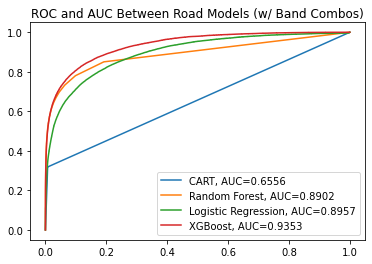

In [ ]:
plt.figure(1).clf()
# CART roads
y_pred = cart_roads_proba
fpr, tpr, _ = metrics.roc_curve(y_test_roads, y_pred)
auc = round(metrics.roc_auc_score(y_test_roads, y_pred), 4)
plt.plot(fpr,tpr,label="CART, AUC="+str(auc));

# RF roads
y_pred = rf_roads_proba
fpr, tpr, _ = metrics.roc_curve(y_test_roads, y_pred)
auc = round(metrics.roc_auc_score(y_test_roads, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc));

# LR roads
y_pred = lr_roads_proba
fpr, tpr, _ = metrics.roc_curve(y_test_roads, y_pred)
auc = round(metrics.roc_auc_score(y_test_roads, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc));

# XGB roads
y_pred = xgb_roads_proba
fpr, tpr, _ = metrics.roc_curve(y_test_roads, y_pred)
auc = round(metrics.roc_auc_score(y_test_roads, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc));

plt.title("ROC and AUC Between Road Models (w/ Band Combos)");
plt.legend();

Landcover: Comparing ROC Curves and AUCs between all 4 landcover models

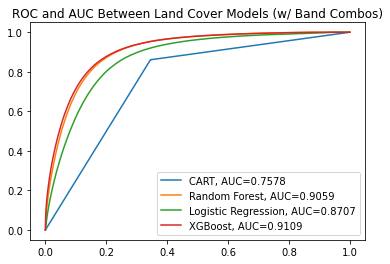

In [ ]:
plt.figure(1).clf()
# CART land
y_pred = cart_land_proba
fpr, tpr, _ = metrics.roc_curve(y_test_land, y_pred)
auc = round(metrics.roc_auc_score(y_test_land, y_pred), 4)
plt.plot(fpr,tpr,label="CART, AUC="+str(auc));

# RF land
y_pred = rf_land_proba
fpr, tpr, _ = metrics.roc_curve(y_test_land, y_pred)
auc = round(metrics.roc_auc_score(y_test_land, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc));

# LR land
y_pred = lr_land_proba
fpr, tpr, _ = metrics.roc_curve(y_test_land, y_pred)
auc = round(metrics.roc_auc_score(y_test_land, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc));

# XGB land
y_pred = xgb_land_proba
fpr, tpr, _ = metrics.roc_curve(y_test_land, y_pred)
auc = round(metrics.roc_auc_score(y_test_land, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc));

plt.title("ROC and AUC Between Land Cover Models (w/ Band Combos)");
plt.legend();